In [1]:
import sys,os
sys.path.append(os.path.abspath("../"))
sys.path.append(os.path.abspath('../modules/'))
import time
import healpy as h
from modules.flat_sky_codes import tangent_plane_analysis as tpa
from modules.flat_sky_codes import flat_sky_analysis as fsa
from modules.masking import gen_masks as gm
from modules.settings import global_mmf_settings as gset
from data_preprocess import tiling_the_sphere as tts
from data_preprocess import tile_planck_data as tpd
from simulate import cluster_templates as cltemp
from filters import modular_multi_matched_filter as mmf
from data_preprocess import get_tangent_planes as gtp
from data_preprocess import tiling_the_sphere as tts
from simulate.spatial_template import sim_cluster as sc
from astropy.io import fits
from simulate.spatial_template import sz_pressure_profile as szp
from read_write_dict import write_dict
from read_write_dict import read_dict
import multiprocessing as mp
import collections

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Circle
def colorbar(mappable):
	ax = mappable.axes
	fig = ax.figure
	divider = make_axes_locatable(ax)
	cax = divider.append_axes("right", size="5%", pad=0.05)
	return fig.colorbar(mappable, cax=cax)


def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

%pylab notebook

Populating the interactive namespace from numpy and matplotlib


/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['colorbar']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
dataset="planck_pr3"
whichch="hfi"
mask_point_sources=False
numprocs=35

if whichch=="allch":
    chmin=30.
elif whichch=="hfi":
    chmin=100.

use_psf_data=True
ps_suffix="_inpainted_data"
if mask_point_sources:
    use_psf_data=False
    ps_suffix="_masked_data"
    
    
figstamp=dataset + "_" + whichch + ps_suffix
dir_suffix=whichch + ps_suffix

save_results=False
run_analysis=False

figstamp,dir_suffix

outpath="/results/" + dataset + "/planck_cat_" + dir_suffix + "/"
tempdatapath="/tempdata/" + dataset + "/planck_tiles/"
gset.setup_mmf_config(dataset=dataset,outpath=outpath,tempdatapath=tempdatapath,chmin=chmin,xsize=15.,do_band_pass=True,use_psf_data=use_psf_data)
figpath=gset.mmfset.paths["result_figs"]
datapath=gset.mmfset.paths["result_data"]

/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


<IPython.core.display.Javascript object>


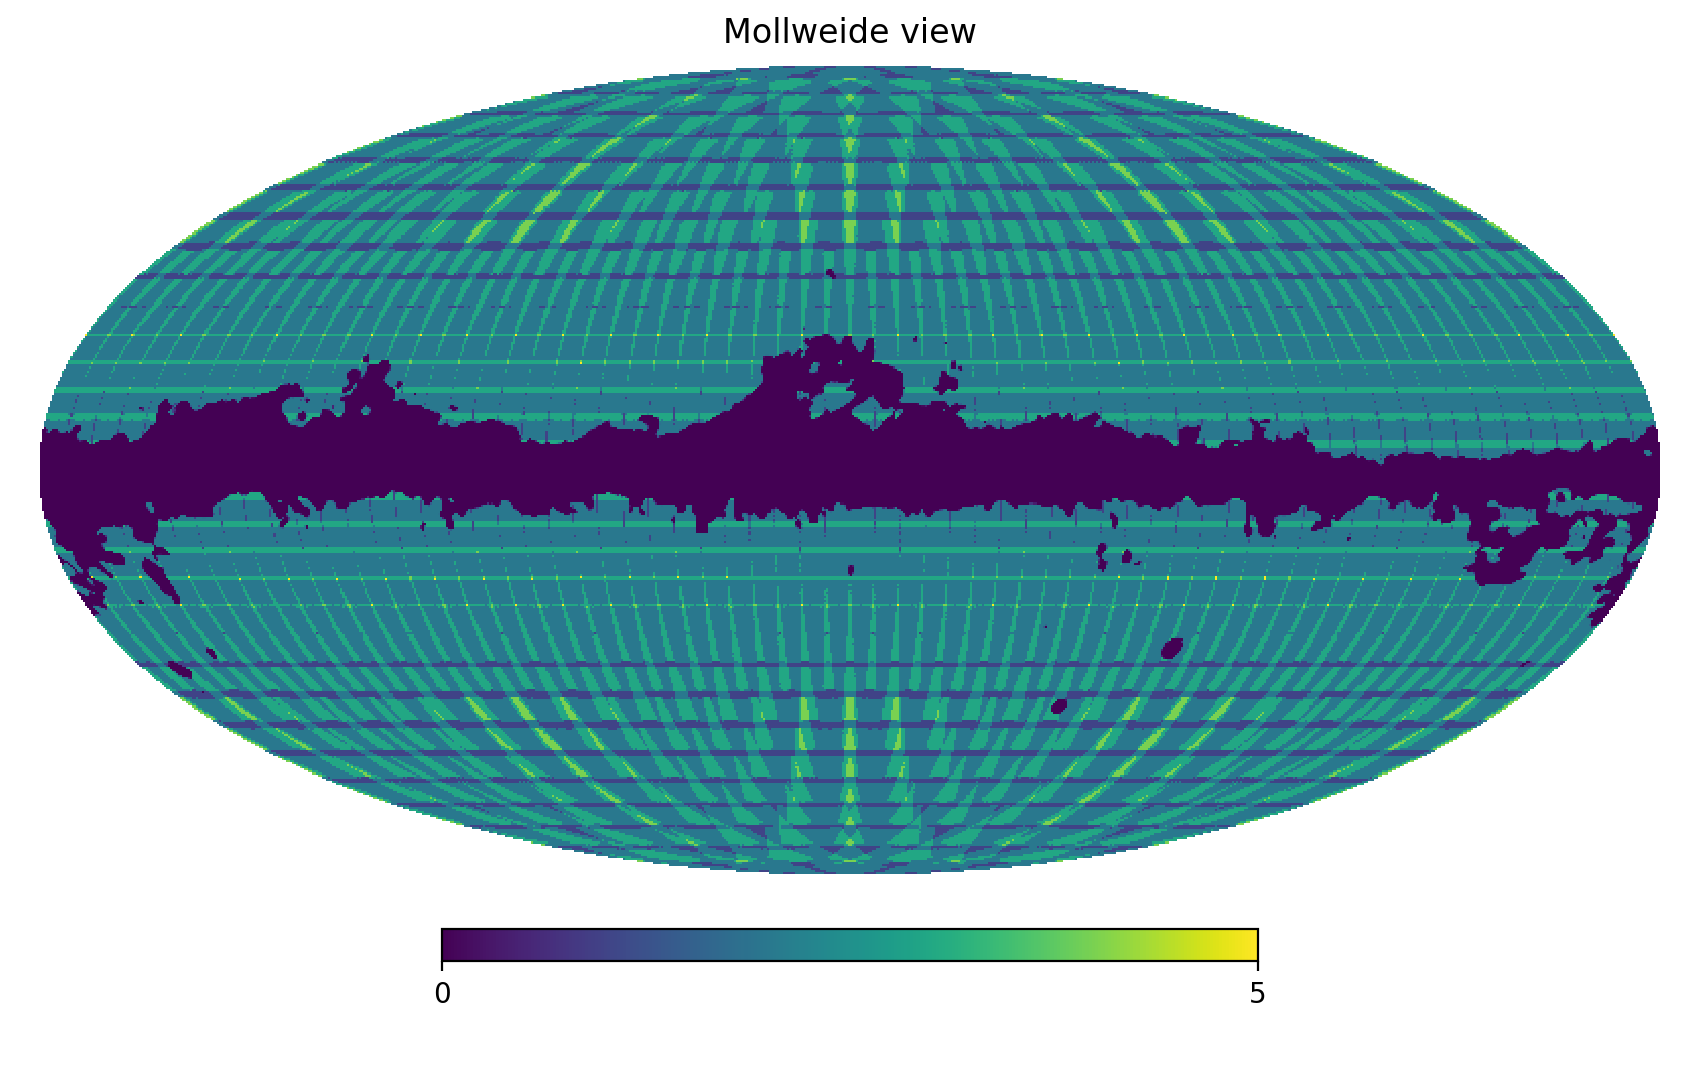

In [3]:
tile_map,fsky_map,apo_mask=tts.return_sky_tile_map()
tiledef=tpd.get_tangent_plane_fnames(fsky_map=fsky_map,fsky_thr=0.3)
h.mollview(tile_map)
filename=figpath + "tile_the_sky.pdf"
plt.savefig(filename,bbox_inches="tight",dpi=200)

In [4]:
# tpd.extract_data_tiles(tiledef)

# def gen_ps_inpainted_data(px):
#     tpd.gen_ps_inpainted_data(px,tiledef)
    
# def parallel_psfill(numprocs):
#     pool=mp.Pool(processes=numprocs)
#     pool.map(gen_ps_inpainted_data,tiledef.keys())
#     pool.close()
#     pool.join()
    
# start=time.time()
# parallel_psfill(8)
# print time.time()-start

In [4]:
tmplt=cltemp.cluster_spectro_spatial_templates(T_step=1.,theta500_min=1.,theta500_max=100.,theta_step=2.)
tmplt.setup_templates()

In [5]:
op=mmf.multi_matched_filter(tmplt.sp_ft_bank,tmplt.sz_spec_bank,tmplt.chfiltr,tmplt.fn_yerr_norm)

In [7]:
def gen_peak_mask(cart_coord,radius):
    ix,iy=cart_coord
    tmask=np.ones((gset.mmfset.npix,gset.mmfset.npix),float)
    distance=np.zeros((gset.mmfset.npix,gset.mmfset.npix),float)
    x,y=np.indices((distance.shape))
    distance=np.sqrt((x-ix)**2. +(y-iy)**2.)*gset.mmfset.reso
    tmask[distance<=radius]=0
    return tmask

def return_cluster_mask(cart_coord,snrmap,snrthr=4,frac=0.7):
    x,y=cart_coord
    pmask=np.zeros_like(snrmap)
    pmask[x,y]=1.
    step=0
#     while all(snrmap[pmask==1]>=snrthr):
#     print sum((snrmap[pmask==1]>=snrthr)*1.)/len((snrmap[pmask==1]>=snrthr))
    while sum((snrmap[pmask==1]>=snrthr)*1.)/len((snrmap[pmask==1]>=snrthr)) > frac:
        step=step+1
        pmask=1-gen_peak_mask(cart_coord,step*gset.mmfset.reso)
#         print sum((snrmap[pmask==1]>=snrthr)*1.)/len((snrmap[pmask==1]>=snrthr))
    radius=(step-1)*gset.mmfset.reso
    return gen_peak_mask(cart_coord,radius)

def return_distance(gal_coord1,gal_coord2):
    glon1,glat1=gal_coord1
    glon2,glat2=gal_coord2
    theta1=(90.-glat1)*np.pi/180.
    theta2=(90.-glat2)*np.pi/180.
    phi1=glon1*np.pi/180.
    phi2=glon2*np.pi/180.
    cosbeta=np.sin(theta1)*np.sin(theta2)*np.cos(phi2-phi1)+np.cos(theta1)*np.cos(theta2)
    cosbeta=np.sign(cosbeta)*min(1.,abs(cosbeta))
    beta=np.arccos(cosbeta)*180.*60./np.pi
    return beta

def return_cartesian_distance(cart_coord1,cart_coord2):
    x1,y1=cart_coord1
    x2,y2=cart_coord2
    beta=np.sqrt((x1-x2)**2. + (y1-y2)**2)*gset.mmfset.reso
    return beta

def myprint(text,verbose):
    if verbose:
        print text

def return_mf_cluster_model(cluscat,snrthr=6.):
    cmodel=np.zeros((gset.mmfset.npix,gset.mmfset.npix),float)
    multi_freq_cluster_model=np.zeros(data.shape,float)
    for ict in cluscat.keys():
        glon,glat=cluscat[ict]["mp_gal_coord"]
        x,y=projop.ang2ij(glon,glat)
        theta500=cluscat[ict]["mp_thetac"]
        yc=cluscat[ict]["mp_yc"]
        if cluscat[ict]["mp_snr"]>snrthr:
            cmodel=cmodel + sc.gen_field_cluster_template(x,y,theta500,yc,gset.mmfset.npix,gset.mmfset.reso)
    cmodel_ft=fsa.map2alm(cmodel,gset.mmfset.reso)
    for i, ch in enumerate(gset.mmfset.channels):
        multi_freq_cluster_model[i,]=fsa.alm2map(cmodel_ft*op.chfiltr[ch]*op.sz_spec_bank[0][ch],gset.mmfset.reso)
    return multi_freq_cluster_model

def return_cluster_cat(data,err,theta500,cluscat,snrthr=4,verbose=False):
    snrthrmask=np.ones_like(data)
    Ycyl2YsphR500=szp.convert_Ycyl_xR500_Ysph_xR500(xcyl=tmplt.cutoff,xsph=1.)
    Ycyl2Ysph5R500=szp.convert_Ycyl_xR500_Ysph_xR500(xcyl=tmplt.cutoff,xsph=5.)
    while (max((data*snrthrmask/err).ravel())>snrthr):
        max_snr=max((data*snrthrmask/err).ravel())
        temp_coord=np.where(data*snrthrmask/err == max_snr) 
        x=temp_coord[0][0] ; y=temp_coord[1][0]
        glon,glat=projop.ij2ang(x,y)
        
        det_cluster=collections.OrderedDict()
        det_cluster["yc"]=[data[x,y]]
        det_cluster["err_yc"]=[err]
        det_cluster["snr"]=[data[x,y]/err]
        det_cluster["thetac"]=[theta500]
        det_cluster["cart_coord"]=[(x,y)]
        det_cluster["gal_coord"]=[(glon,glat)]
        det_cluster["YR500"]=[data[x,y]*tmplt.fn_yerr_norm(theta500)*Ycyl2YsphR500]
        det_cluster["err_YR500"]=[err*tmplt.fn_yerr_norm(theta500)*Ycyl2YsphR500]
        det_cluster["Y5R500"]=[data[x,y]*tmplt.fn_yerr_norm(theta500)*Ycyl2Ysph5R500]
        det_cluster["err_Y5R500"]=[err*tmplt.fn_yerr_norm(theta500)*Ycyl2Ysph5R500]
        
        nc=[]
        for ict in cluscat.keys():
            dist=return_distance(det_cluster["gal_coord"][0],cluscat[ict]["mp_gal_coord"])
            #dist=return_cartesian_distance(det_cluster["cart_coord"],cluscat[ict]["cart_coord"])
            nc=nc + [dist<theta500 or dist<cluscat[ict]["mp_thetac"]]
            
        if any(nc):
            myprint("This cluster exists in the catalogue",verbose)
            match_ict=np.where(nc)[0][0]
            for key in det_cluster.keys():
                cluscat[match_ict][key]=cluscat[match_ict][key] + det_cluster[key]
            if det_cluster["snr"][0]>cluscat[match_ict]["mp_snr"]:
                myprint("Updating the cluster definition",verbose)
                for key in det_cluster.keys():
                    cluscat[match_ict]["mp_" + key]=det_cluster[key][0]
        else:
            myprint("New cluster detected, adding to the cluster catalogue",verbose)
            match_ict=len(cluscat.keys())
            cluscat[match_ict]=det_cluster
            for key in det_cluster.keys():
                cluscat[match_ict]["mp_" + key]=det_cluster[key][0]
        # Here you can define the radius as the size of the cluster of points and that will make it more robust.
        snrthrmask=snrthrmask*gen_peak_mask(det_cluster["cart_coord"][0],max(5.*det_cluster["thetac"][0],15.))
        snrthrmask=snrthrmask*return_cluster_mask(det_cluster["cart_coord"][0],data/err,snrthr=4.)
    return cluscat

def gen_tile_figs(data,theta500,err,cluscat,showplt=False):
    if showplt:
        ion()
    else:
        ioff()
    
    fig, ax1 = plt.subplots(ncols=1)
    snrthrmask[:]=1.
    for ict in tile_char["cat"].keys():
        x,y=cluscat[ict]["mp_cart_coord"]
        snr=cluscat[ict]["mp_snr"]
        radius=(snr)*1.5
        circ = Circle((y,x),radius,edgecolor='red', facecolor="none",alpha=0.85,linewidth=0.8)
        ax1.add_patch(circ)
    img1 = ax1.imshow(data/err,vmin=-3,vmax=6.,origin="lower")
    colorbar(img1)
    ax1.set_title("Filtered data SNR [ $\sigma=$"+ str(round(err*1e5,2)) + r"; $\theta_{500}=$" + str(round(theta500)) + "]",fontsize=8)
    cluspath=figpath + tilename + "/" ; ensure_dir(cluspath)
    filename=cluspath + tilename + "_clusdet_iter" + str(ith).zfill(2) + ".jpeg"
    plt.savefig(filename,bbox_inches="tight",dpi=300)
    
    

In [56]:
tile_cluscat={}
idx=tiledef.keys()[0]
filename=tiledef[idx]["FILENAME"]
tilename=tiledef[idx]["TILENAME"]
emask=gm.return_edge_apodized_mask(edge_width=30,fwhm=30)
ps_mask=gtp.return_ps_mask(filename)
ext_ps_mask=gtp.return_ext_ps_mask(filename)
data=gtp.return_data(filename)
glat=tiledef[idx]["GLAT"]
glon=tiledef[idx]["GLON"]
projop=tpa.tangent_plane_setup(gset.mmfset.nside,gset.mmfset.xsize,glat,glon,rescale=1.)
snrthrmask=np.ones_like(emask)
galmask=fits.getdata(filename,extname="Galactic mask")
gmask=emask*ext_ps_mask*galmask

In [89]:
verbose=False
fildata={}
tile_char=collections.OrderedDict()
tile_char["pix"]=idx
tile_char["theta500"]=np.array([])
tile_char["err_Y500"]=np.array([])
tile_char["cat"]={}
Ycyl2Ysph=szp.convert_Ycyl_xR500_Ysph_xR500(xcyl=tmplt.cutoff,xsph=1)
op.get_data_ft((data*gmask)*emask*ps_mask,emask=emask*galmask)
for ith,theta500 in enumerate(tmplt.theta500[::-1]):
    fdata,err,snr,yc=op.return_snr(theta500,0.,mask_fdata=False)
    fildata[theta500]=fdata
    fsky=np.sum(galmask)/size(galmask) ; tile_char["fsky"]=fsky
    err=err/np.sqrt(fsky)
    tile_char["theta500"]=np.append(tile_char["theta500"],theta500)
    tile_char["err_Y500"]=np.append(tile_char["err_Y500"],err*tmplt.fn_yerr_norm(theta500)*Ycyl2Ysph)
    tile_char["cat"]=return_cluster_cat(fdata*gmask,err,theta500,tile_char["cat"],snrthr=4.,verbose=False)
    
#     gen_tile_figs(fdata,theta500,err,tile_char["cat"],showplt=False)
    
#     fig, ax1 = plt.subplots(ncols=1)
#     snrthrmask[:]=1.
#     for ict in tile_char["cat"].keys():
#         x,y=tile_char["cat"][ict]["mp_cart_coord"]
#         snr=tile_char["cat"][ict]["mp_snr"]
#         radius=(snr)*1.5
#         if snr>=6:
#             circ = Circle((y,x),radius,edgecolor='green', facecolor="none",alpha=0.85,linewidth=0.9)
#         else:
#             circ = Circle((y,x),radius,edgecolor='red', facecolor="none",alpha=0.85,linewidth=0.9)
#         ax1.add_patch(circ)
#     img1 = ax1.imshow(fdata*gmask/err,vmin=-2,vmax=6,origin="lower",cmap="cividis")
#     colorbar(img1)
#     ax1.set_title("Filtered data SNR [ $\sigma=$"+ str(round(err*1e5,2)) + r"; $\theta_{500}=$" + str(round(theta500)) + "]",fontsize=8)
#     cluspath=figpath + tilename + "/" ; ensure_dir(cluspath)
#     filename=cluspath + tilename + "_clusdet_iter" + str(ith).zfill(2) + ".jpeg"
#     savefig(filename,bbox_inches="tight",dpi=300)

<IPython.core.display.Javascript object>


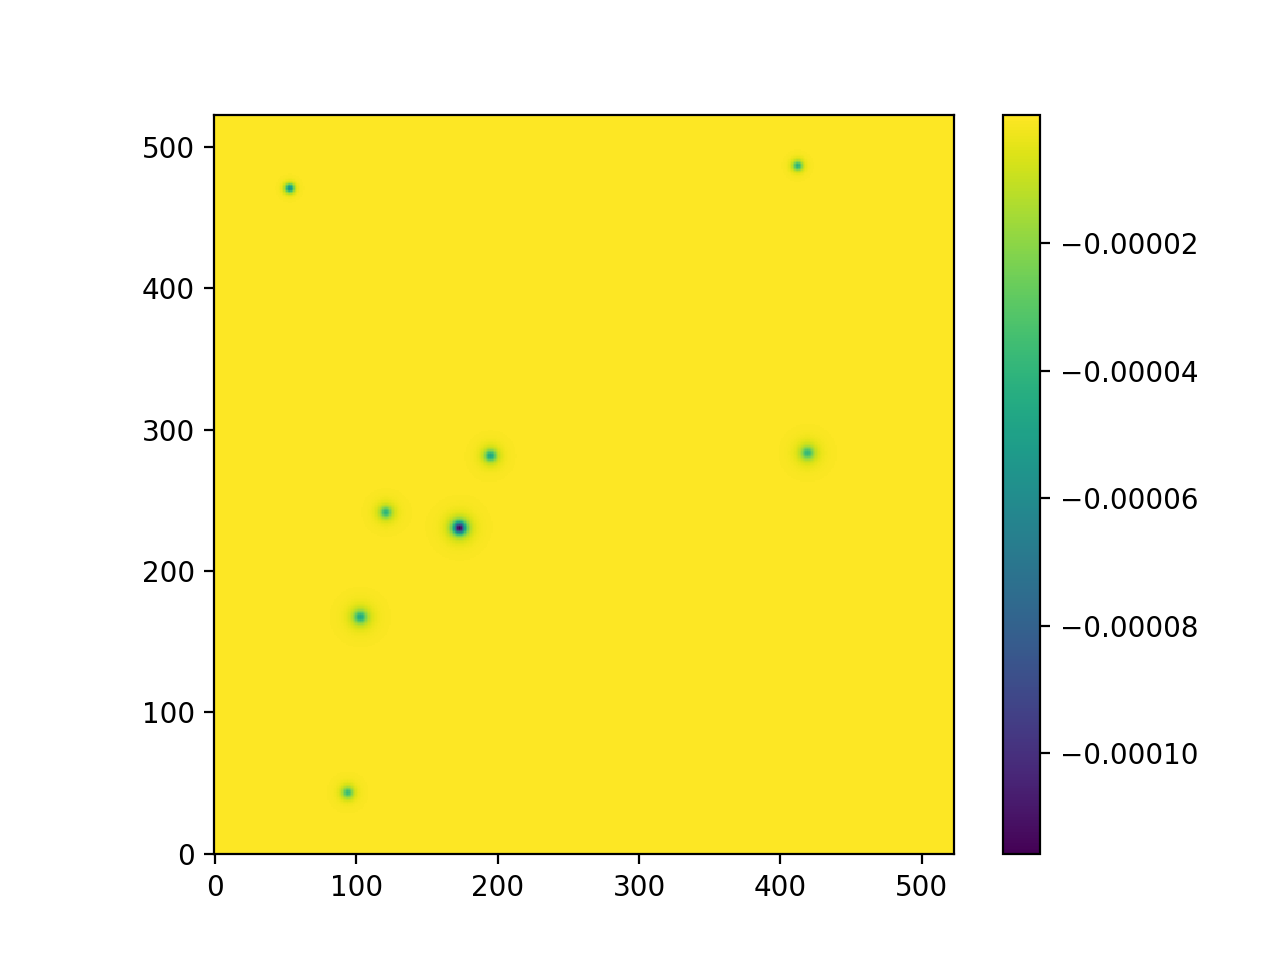

In [90]:
mfcm=return_mf_cluster_model(tile_char['cat'],snrthr=6.)
figure()
img=imshow(mfcm[1,],origin="lower")
colorbar(img)

In [96]:
op1=mmf.multi_matched_filter(tmplt.sp_ft_bank,tmplt.sz_spec_bank,tmplt.chfiltr,tmplt.fn_yerr_norm)
op1.get_data_ft(((data-mfcm)*gmask)*emask*ps_mask,emask=emask*galmask,mfcm=mfcm)

In [97]:
theta500=11.
fdata1,err1,snr1,yc1=op1.return_snr(theta500,0.,mask_fdata=False)
fdata,err,snr,yc=op.return_snr(theta500,0.,mask_fdata=False)

In [98]:
err/err1

0.9951301734186901

<IPython.core.display.Javascript object>


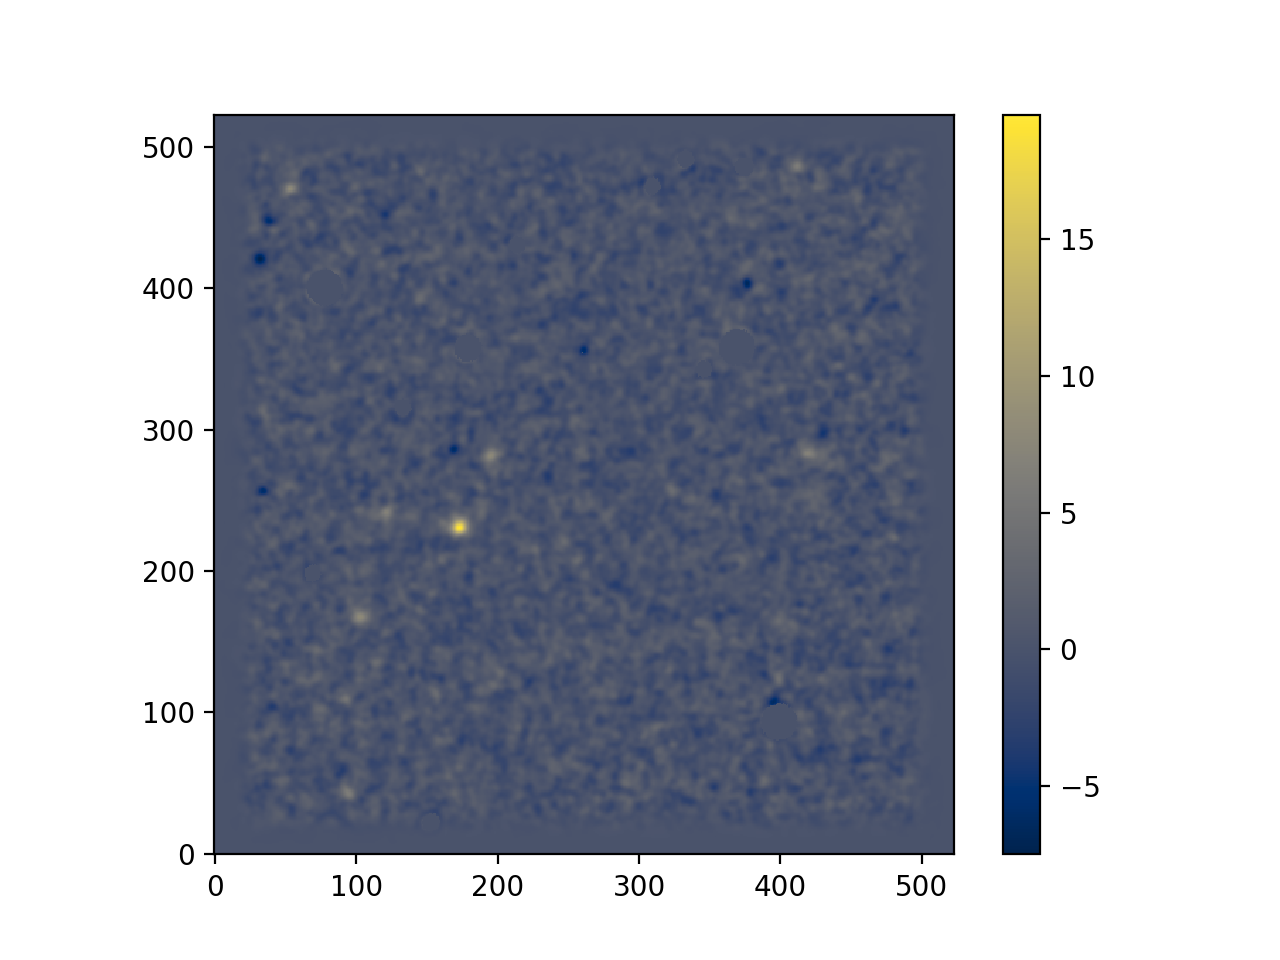

<IPython.core.display.Javascript object>


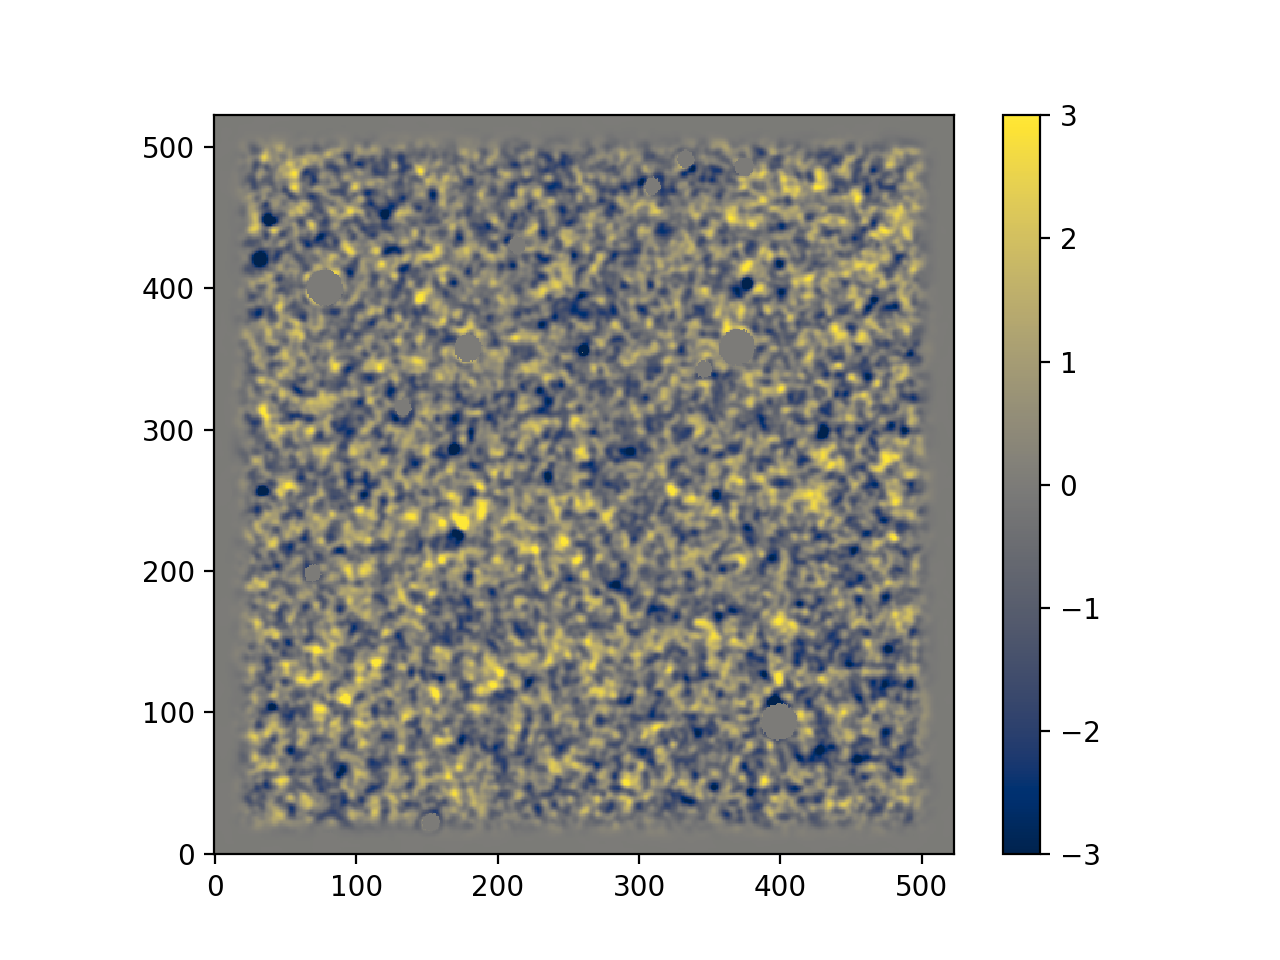

In [101]:
figure()
img=imshow(fdata*gmask/err,origin="lower",cmap="cividis")
colorbar(img)

figure()
img1=imshow(fdata1*gmask/err1,vmin=-3,vmax=3,origin="lower",cmap="cividis")
colorbar(img1)

<IPython.core.display.Javascript object>


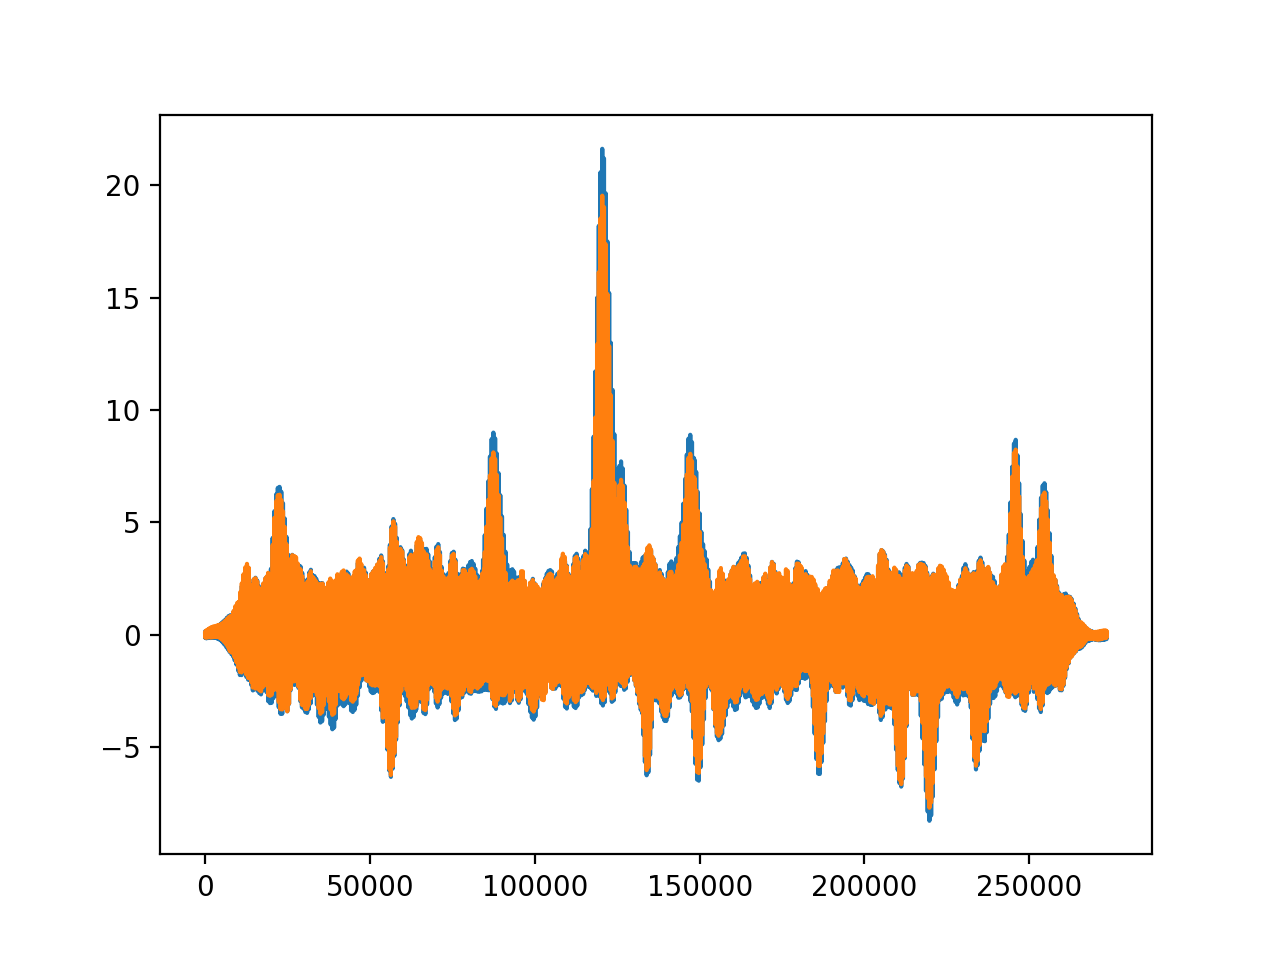

In [95]:
figure()
plot(fdata1.ravel()/err1)
plot(fdata.ravel()/err)

In [5]:
from automated_detection import extract_tile_cluster_catalogue_v1 as etcc

In [9]:
emask=etcc.emask
def extract_tile_cluster_catalogue(tile_px,tiledef,tmplt,genfig=True,snrthr=4,doiter=True,verbose=True):
	filename=tiledef[tile_px]["FILENAME"]
	tilename=tiledef[tile_px]["TILENAME"]
	ext_ps_mask=gtp.return_ext_ps_mask(filename)
	ps_mask=gtp.return_ps_mask(filename)
	gmask=gtp.return_galactic_mask(filename)
	ana_mask=gmask*ps_mask*emask ; fsky=np.sum(ana_mask)/np.size(ana_mask)
	det_mask=gmask*ext_ps_mask*emask
	data=gtp.return_data(filename) ; data=data*ana_mask
	glon=tiledef[tile_px]["GLON"] ; glat=tiledef[tile_px]["GLAT"]
	projop=tpa.tangent_plane_setup(gset.mmfset.nside,gset.mmfset.xsize,glat,glon,rescale=1.)
	cluspath=gset.mmfset.paths["result_figs"] + tilename + "/" ; ensure_dir(cluspath)
	Ycyl2YsphR500=szp.convert_Ycyl_xR500_Ysph_xR500(xcyl=tmplt.cutoff,xsph=1.)

	tile_char=collections.OrderedDict()
	tile_char["pix"]=tile_px
	tile_char["fsky"]=fsky
	tile_char["theta500"]=np.array([])
	tile_char["conv_yc2Y500"]=np.array([])
	fildata={}

	opmmf=mmf.multi_matched_filter(tmplt.sp_ft_bank,tmplt.sz_spec_bank,tmplt.chfiltr,tmplt.fn_yerr_norm)

	opmmf.get_data_ft(data,emask=ana_mask)
	fildata["iter0"]={} ; tile_char["cat"]={} ; tile_char["err_Y500"]=np.array([])
	for ith,theta500 in enumerate(tmplt.theta500[::-1]):
		fdata,err,snr,yc=opmmf.return_snr(theta500,0.,mask_fdata=False)
		fildata["iter0"][theta500]=fdata*det_mask
		err=err/np.sqrt(tile_char["fsky"])
		tile_char["theta500"]=np.append(tile_char["theta500"],theta500)
		tile_char["err_Y500"]=np.append(tile_char["err_Y500"],err*tmplt.fn_yerr_norm(theta500)*Ycyl2YsphR500)
		tile_char["conv_yc2Y500"]=np.append(tile_char["conv_yc2Y500"],tmplt.fn_yerr_norm(theta500)*Ycyl2YsphR500)
		tile_char["cat"]=return_cluster_cat(fdata*det_mask,err,theta500,tile_char["cat"],projop,tmplt,snrthr=snrthr,verbose=verbose)


	if doiter:
		mfcm=return_mf_cluster_model(tile_char["cat"],projop=projop,opmmf=opmmf,snrthr=6.)
		opmmf.get_data_ft(data,emask=gmask*emask*ps_mask,mfcm=mfcm)
		fildata["iter1"]={} ; tile_char["cat_rev"]={} ; tile_char["err_Y500_rev"]=np.array([])
		for ith,theta500 in enumerate(tmplt.theta500[::-1]):
			fdata,err,snr,yc=opmmf.return_snr(theta500,0.,mask_fdata=False)
			fildata["iter1"][theta500]=fdata*det_mask
			err=err/np.sqrt(tile_char["fsky"])
			tile_char["err_Y500_rev"]=np.append(tile_char["err_Y500_rev"],err*tmplt.fn_yerr_norm(theta500)*Ycyl2YsphR500)
			tile_char["cat_rev"]=return_cluster_cat(fdata*det_mask,err,theta500,tile_char["cat_rev"],projop,tmplt,snrthr=snrthr,verbose=verbose)

	filename=cluspath + tilename + "_clusdet_iter" + str(ith).zfill(2) + ".jpeg"
	write_dict(tiledef[tile_px]["CATNAME"],tile_char)
	return tile_char,fildata

def return_cluster_cat(data,err,theta500,cluscat,projop,tmplt,snrthr=4,verbose=False):
    snrthrmask=np.ones_like(data)
    Ycyl2YsphR500=szp.convert_Ycyl_xR500_Ysph_xR500(xcyl=tmplt.cutoff,xsph=1.)
    Ycyl2Ysph5R500=szp.convert_Ycyl_xR500_Ysph_xR500(xcyl=tmplt.cutoff,xsph=5.)
    while (max((data*snrthrmask/err).ravel())>snrthr):
        max_snr=max((data*snrthrmask/err).ravel())
        temp_coord=np.where(data*snrthrmask/err == max_snr)
        x=temp_coord[0][0] ; y=temp_coord[1][0]
        glon,glat=projop.ij2ang(x,y)

        det_cluster=collections.OrderedDict()
        det_cluster["yc"]=[data[x,y]]
        det_cluster["err_yc"]=[err]
        det_cluster["snr"]=[data[x,y]/err]
        det_cluster["thetac"]=[theta500]
        det_cluster["cart_coord"]=[(x,y)]
        det_cluster["gal_coord"]=[(glon,glat)]
        det_cluster["YR500"]=[data[x,y]*tmplt.fn_yerr_norm(theta500)*Ycyl2YsphR500]
        det_cluster["err_YR500"]=[err*tmplt.fn_yerr_norm(theta500)*Ycyl2YsphR500]
        det_cluster["Y5R500"]=[data[x,y]*tmplt.fn_yerr_norm(theta500)*Ycyl2Ysph5R500]
        det_cluster["err_Y5R500"]=[err*tmplt.fn_yerr_norm(theta500)*Ycyl2Ysph5R500]

        nc=[]
        for ict in cluscat.keys():
            dist=return_distance(det_cluster["gal_coord"][0],cluscat[ict]["mp_gal_coord"])
            #dist=return_cartesian_distance(det_cluster["cart_coord"],cluscat[ict]["cart_coord"])
            nc=nc + [dist<theta500 or dist<cluscat[ict]["mp_thetac"]]

        if any(nc):
            myprint("This cluster exists in the catalogue",verbose)
            match_ict=np.where(nc)[0][0]
            mask_center=cluscat[match_ict]["mp_cart_coord"]
            mask_thetac=cluscat[match_ict]["mp_thetac"]
            
            for key in det_cluster.keys():
                cluscat[match_ict][key]=cluscat[match_ict][key] + det_cluster[key]
            if det_cluster["snr"][0]>cluscat[match_ict]["mp_snr"]:
                myprint("Updating the cluster definition",verbose)
                for key in det_cluster.keys():
                    cluscat[match_ict]["mp_" + key]=det_cluster[key][0]
        else:
            myprint("New cluster detected, adding to the cluster catalogue",verbose)
            match_ict=len(cluscat.keys())
            mask_center=det_cluster["cart_coord"][0]
            mask_thetac=det_cluster["thetac"][0]
            cluscat[match_ict]=det_cluster
            for key in det_cluster.keys():
                cluscat[match_ict]["mp_" + key]=det_cluster[key][0]
        # Here you can define the radius as the size of the cluster of points and that will make it more robust.
#         snrthrmask=snrthrmask*gen_peak_mask(det_cluster["cart_coord"][0],max(5.*det_cluster["thetac"][0],15.))
#         snrthrmask=snrthrmask*return_cluster_mask(det_cluster["cart_coord"][0],data/err,snrthr=3.,frac=0.3)
        snrthrmask=snrthrmask*gen_peak_mask(mask_center,max(2.*mask_thetac,15.))
        snrthrmask=snrthrmask*return_cluster_mask(mask_center,data/err,snrthr=3.,frac=0.3)
    return cluscat

def myprint(text,verbose):
    if verbose:
        print text

def gen_peak_mask(cart_coord,radius):
    ix,iy=cart_coord
    tmask=np.ones((gset.mmfset.npix,gset.mmfset.npix),np.float64)
    distance=np.zeros((gset.mmfset.npix,gset.mmfset.npix),np.float64)
    x,y=np.indices((distance.shape))
    distance=np.sqrt((x-ix)**2. +(y-iy)**2.)*gset.mmfset.reso
    tmask[distance<=radius]=0
    return tmask

# The functions below do not depend on the location of the tile.
def return_cluster_mask(cart_coord,snrmap,snrthr=4,frac=0.7):
    '''
    frac: Number of pixels you want to be above the snr thresholds
    '''
    x,y=cart_coord
    pmask=np.zeros_like(snrmap)
    pmask[x,y]=1.
    step=0
    #     while all(snrmap[pmask==1]>=snrthr):
    while sum((snrmap[pmask==1]>=snrthr)*1.)/len((snrmap[pmask==1]>=snrthr)) > frac:
        step=step+1
        pmask=1-gen_peak_mask(cart_coord,step*gset.mmfset.reso)
    radius=(step-1)*gset.mmfset.reso
    return gen_peak_mask(cart_coord,radius)

def return_mf_cluster_model(cluscat,projop,opmmf,snrthr=6.):
	cmodel=return_cluster_model(cluscat,projop,snrthr)
	#    cmodel=np.zeros((gset.mmfset.npix,gset.mmfset.npix),float)
	#    for ict in cluscat.keys():
	#        glon,glat=cluscat[ict]["mp_gal_coord"]
	#        x,y=projop.ang2ij(glon,glat)
	#        theta500=cluscat[ict]["mp_thetac"]
	#        yc=cluscat[ict]["mp_yc"]
	#        if cluscat[ict]["mp_snr"]>snrthr:
	#        	cmodel=cmodel + sc.gen_field_cluster_template(x,y,theta500,yc,gset.mmfset.npix,gset.mmfset.reso)
	multi_freq_cluster_model=np.zeros((np.size(gset.mmfset.channels),gset.mmfset.npix,gset.mmfset.npix),np.float64)
	cmodel_ft=fsa.map2alm(cmodel,gset.mmfset.reso)
	for i, ch in enumerate(gset.mmfset.channels):
		multi_freq_cluster_model[i,]=fsa.alm2map(cmodel_ft*opmmf.chfiltr[ch]*opmmf.sz_spec_bank[0][ch],gset.mmfset.reso)
	return multi_freq_cluster_model

def return_cluster_model(cluscat,projop,snrthr=6.):
	cmodel=np.zeros((gset.mmfset.npix,gset.mmfset.npix),float)
	for ict in cluscat.keys():
		glon,glat=cluscat[ict]["mp_gal_coord"]
		x,y=projop.ang2ij(glon,glat)
		theta500=cluscat[ict]["mp_thetac"]
		yc=cluscat[ict]["mp_yc"]
		if cluscat[ict]["mp_snr"]>=snrthr:
			cmodel=cmodel + sc.gen_field_cluster_template(x,y,theta500,yc,gset.mmfset.npix,gset.mmfset.reso)
	return cmodel

def return_distance(gal_coord1,gal_coord2):
    glon1,glat1=gal_coord1
    glon2,glat2=gal_coord2
    theta1=(90.-glat1)*np.pi/180.
    theta2=(90.-glat2)*np.pi/180.
    phi1=glon1*np.pi/180.
    phi2=glon2*np.pi/180.
    cosbeta=np.sin(theta1)*np.sin(theta2)*np.cos(phi2-phi1)+np.cos(theta1)*np.cos(theta2)
    cosbeta=np.sign(cosbeta)*min(np.abs(cosbeta),1.)
    if abs(cosbeta)>1.:
    	print cosbeta,glon1,glat1,glon2,glat2
    beta=np.arccos(cosbeta)*180.*60./np.pi
    return beta

def return_cartesian_distance(cart_coord1,cart_coord2):
    x1,y1=cart_coord1
    x2,y2=cart_coord2
    beta=np.sqrt((x1-x2)**2. + (y1-y2)**2)*gset.mmfset.reso
    return beta

def gen_tile_figs(tilecat,fildata,cluspath,tilename,showplt=False,gengif=False):
	plt.ioff()
	if showplt:
		plt.ion()

	ang_dist=gset.mmfset.npix*gset.mmfset.reso/2./60.
	extent=[-ang_dist,ang_dist,-ang_dist,ang_dist]
	for ith, thc in enumerate(tilecat["theta500"]):
		fig, (ax1, ax2)=plt.subplots(ncols=2)
		for ict in tilecat["cat"].keys():
			if thc in tilecat["cat"][ict]["thetac"]:
				idx=np.where(np.array(tilecat["cat"][ict]["thetac"])==thc)[0][0]
				x,y=tilecat["cat"][ict]["cart_coord"][idx]
				x=x*gset.mmfset.reso/60. - ang_dist
				y=y*gset.mmfset.reso/60. - ang_dist
				snr=tilecat["cat"][ict]["snr"][idx]
			elif thc <=tilecat["cat"][ict]["mp_thetac"]:
				x,y=tilecat["cat"][ict]["mp_cart_coord"]
				x=x*gset.mmfset.reso/60. - ang_dist
				y=y*gset.mmfset.reso/60. - ang_dist
				snr=tilecat["cat"][ict]["mp_snr"]

			radius=(snr)*2.*gset.mmfset.reso/60.

			if snr>=6:
				circ = Circle((y,x),radius,edgecolor='green', facecolor="none",alpha=0.85,linewidth=1.2)
			elif snr>=5 and snr<6:
				circ = Circle((y,x),radius,edgecolor='magenta', facecolor="none",alpha=0.85,linewidth=1.2)
			else:
				circ = Circle((y,x),radius,edgecolor='red', facecolor="none",alpha=0.85,linewidth=0.8)
			ax1.add_patch(circ)
		img1 = ax1.imshow(fildata["iter0"][thc]/tilecat["err_yc"][ith],vmin=-2,vmax=6,origin="lower",cmap="cividis",extent=extent)
		colorbar(img1)
		ax1.set_title("Filtered data SNR [ $\sigma=$"+ str(round(tilecat["err_yc"][ith]*1e5,2)) + r"; $\theta_{500}=$" + str(round(thc)) + "]",fontsize=8)

		for ict in tilecat["cat_rev"].keys():
			if thc in tilecat["cat_rev"][ict]["thetac"]:
				idx=np.where(np.array(tilecat["cat_rev"][ict]["thetac"])==thc)[0][0]
				x,y=tilecat["cat_rev"][ict]["cart_coord"][idx]
				x=x*gset.mmfset.reso/60. - ang_dist
				y=y*gset.mmfset.reso/60. - ang_dist
				snr=tilecat["cat_rev"][ict]["snr"][idx]
			elif thc <=tilecat["cat_rev"][ict]["mp_thetac"]:
				x,y=tilecat["cat_rev"][ict]["mp_cart_coord"]
				x=x*gset.mmfset.reso/60. - ang_dist
				y=y*gset.mmfset.reso/60. - ang_dist
				snr=tilecat["cat_rev"][ict]["mp_snr"]

			radius=(snr)*2.*gset.mmfset.reso/60.

			if snr>=6:
				circ = Circle((y,x),radius,edgecolor='green', facecolor="none",alpha=0.85,linewidth=1.2)
			elif snr>=5 and snr<6:
				circ = Circle((y,x),radius,edgecolor='magenta', facecolor="none",alpha=0.85,linewidth=1.2)
			else:
				circ = Circle((y,x),radius,edgecolor='red', facecolor="none",alpha=0.85,linewidth=0.8)
			ax2.add_patch(circ)
		img2 = ax2.imshow(fildata["iter1"][thc]/tilecat["err_yc"][ith],vmin=-2,vmax=6,origin="lower",cmap="cividis",extent=extent)
		colorbar(img2)
		ax2.set_title("Filtered data SNR [ $\sigma=$"+ str(round(tilecat["err_yc_rev"][ith]*1e5,2)) + r"; $\theta_{500}=$" + str(round(thc)) + "]",fontsize=8)

		plt.tight_layout(h_pad=1)
		filename=cluspath + tilename + "_clusdet_iter" + str(ith).zfill(2) + ".jpeg"
		plt.savefig(filename,bbox_inches="tight",dpi=200)
		plt.clf()
		plt.close()
	
	if gengif:
		cmd="convert -delay 50 " + cluspath + "*.jpeg " + cluspath + tilename + "def.gif"
		os.system(cmd)

In [8]:
import time
start=time.time()
px=tiledef.keys()[4]
glon=tiledef[px]["GLON"] ; glat=tiledef[px]["GLAT"]
projop=tpa.tangent_plane_setup(gset.mmfset.nside,gset.mmfset.xsize,glat,glon,rescale=1.)
cat,fildata=etcc.extract_tile_cluster_catalogue(px,tiledef,tmplt,genfig=True)
print time.time()-start

326.158102989


In [8]:
print cat["cat"].keys()
print cat["cat_rev"].keys()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [10]:
tilename=tiledef[px]["TILENAME"]
cluspath=gset.mmfset.paths["result_figs"] + tilename + "/" ; ensure_dir(cluspath)

gen_tile_figs(cat,fildata,cluspath,tilename,showplt=False,gengif=True)

<IPython.core.display.Javascript object>


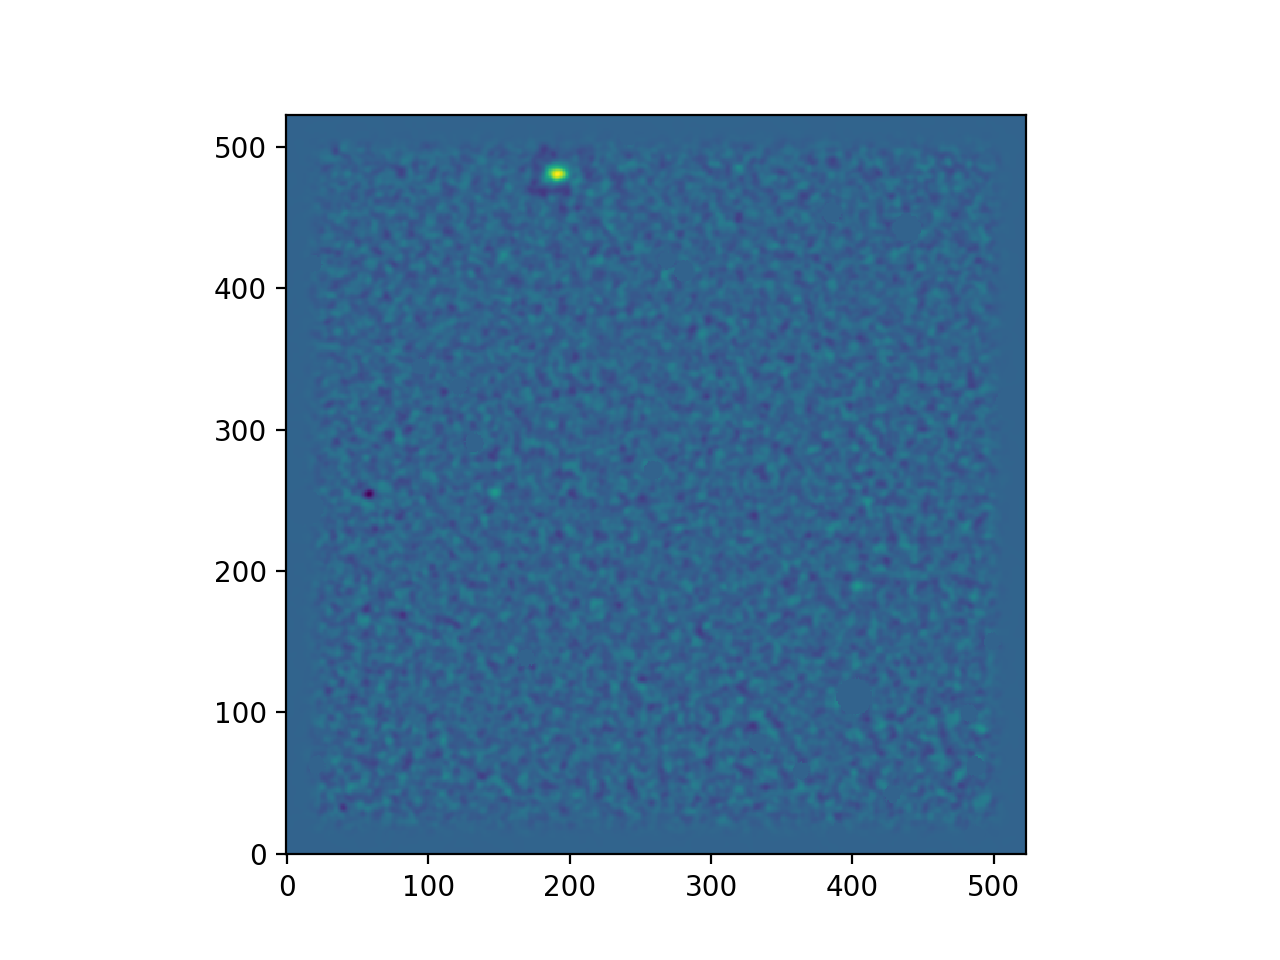

<IPython.core.display.Javascript object>


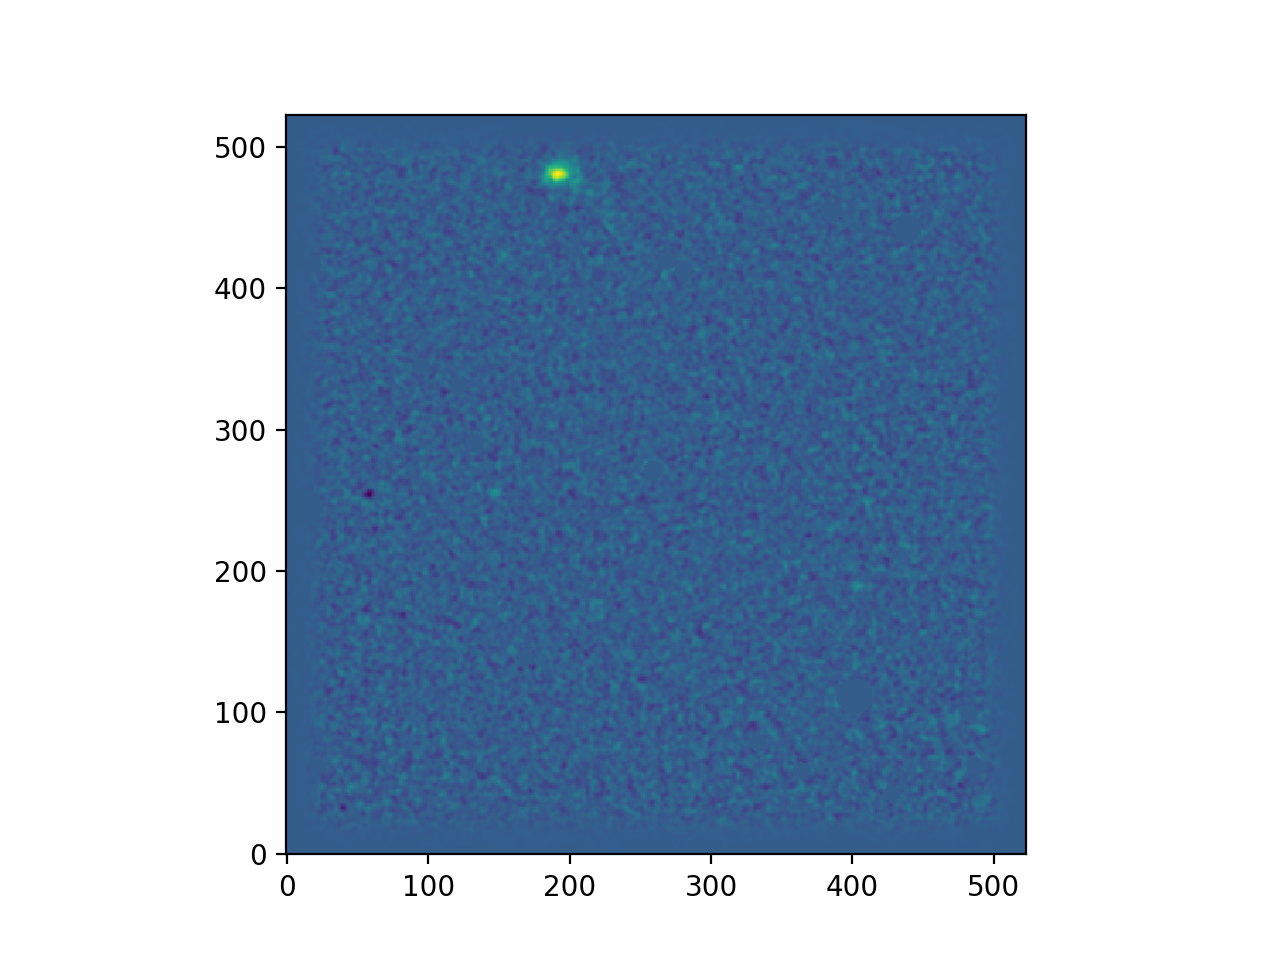

In [14]:
figure()
imshow(fildata["iter0"][7],origin="lower")

figure()
imshow(fildata["iter1"][1],origin="lower")

In [19]:
cat1,fildata1=extract_tile_cluster_catalogue(px,tiledef,tmplt,genfig=True,snrthr=4,doiter=True,verbose=False)

In [20]:
print cat1["cat"].keys()
print cat1["cat_rev"].keys()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [21]:
len(cat1["cat_rev"][0]["snr"])

51

<IPython.core.display.Javascript object>


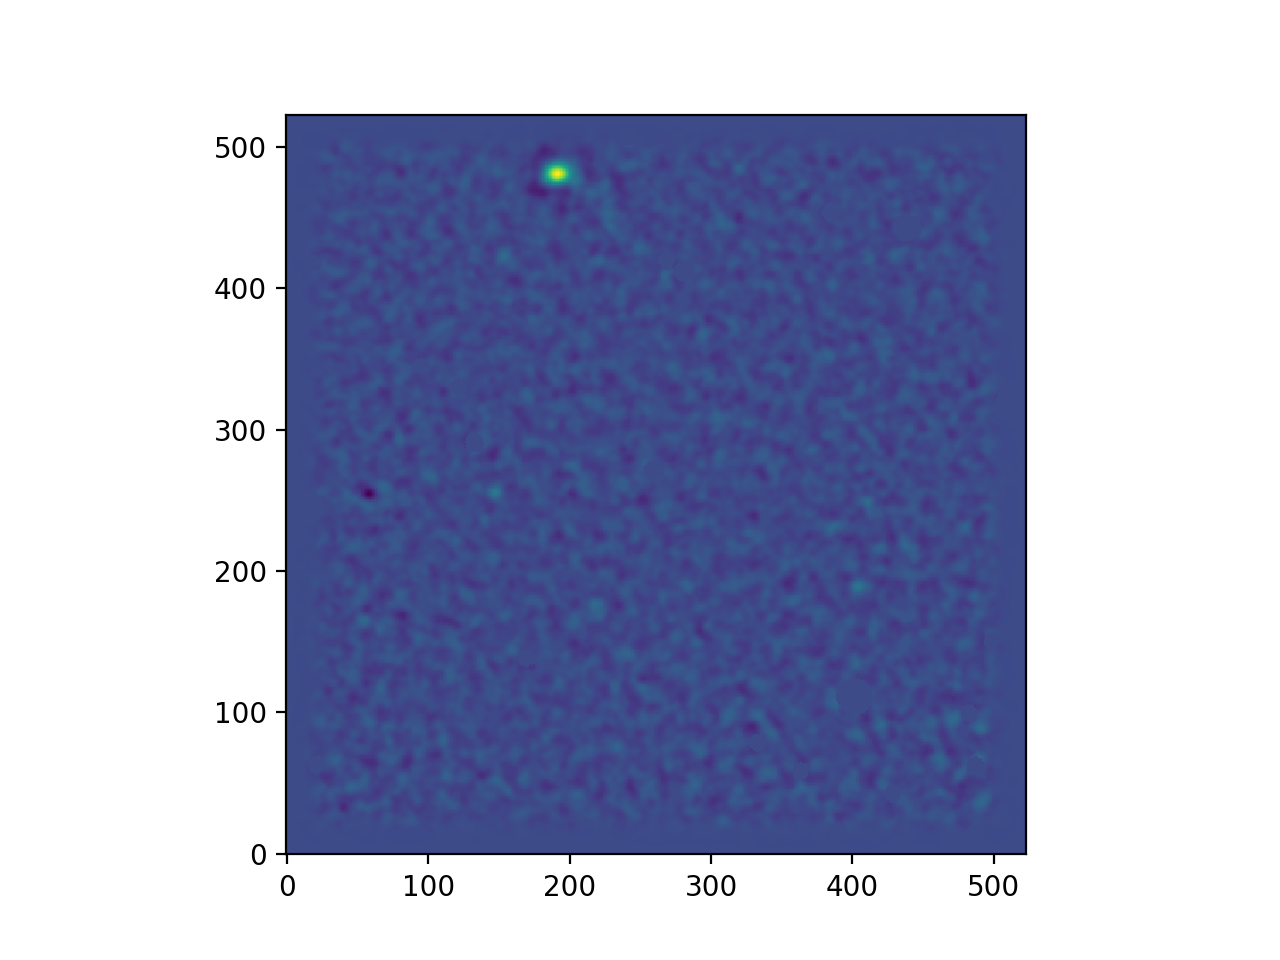

<IPython.core.display.Javascript object>


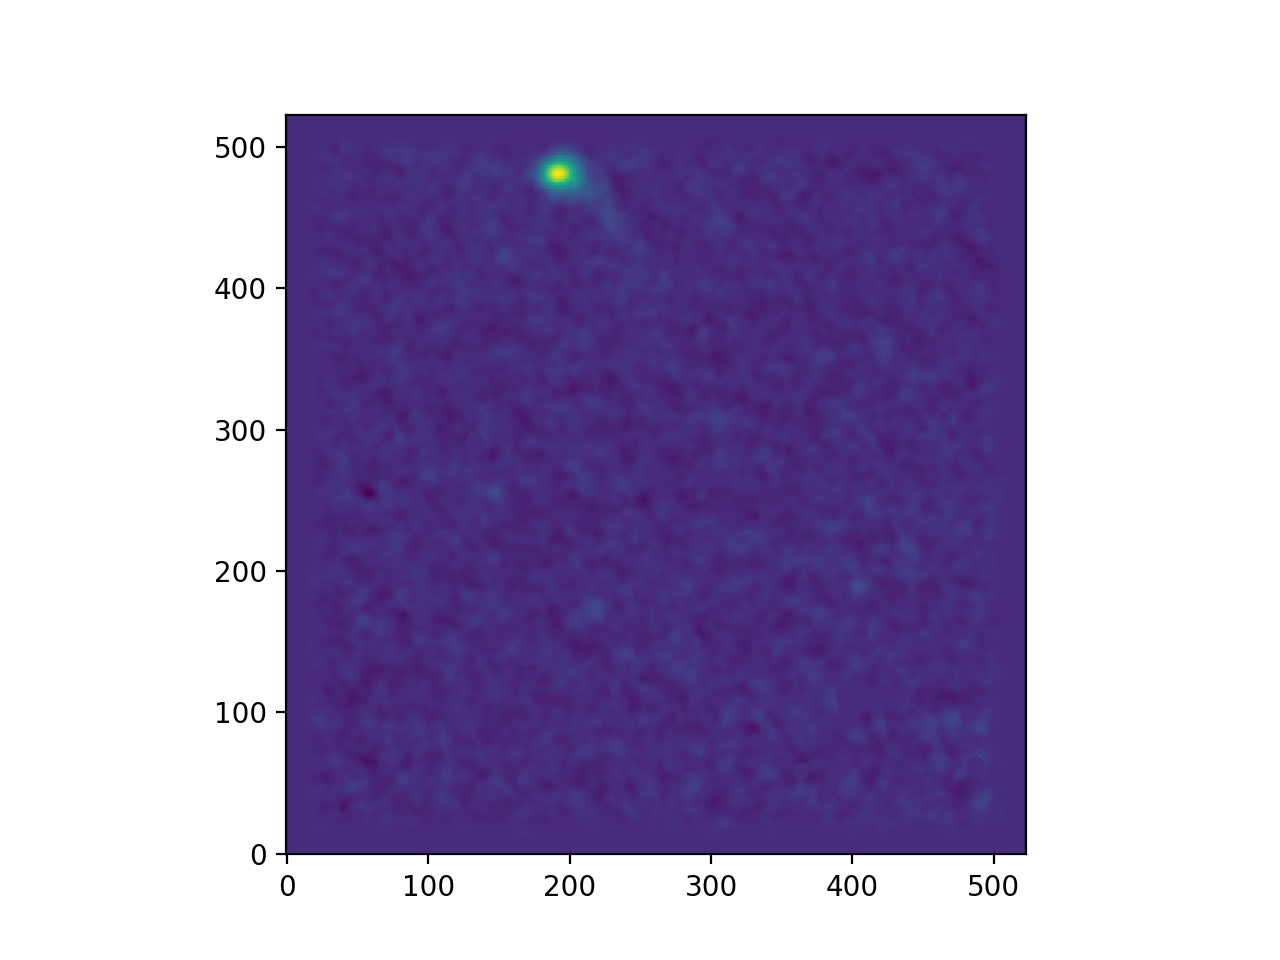

In [17]:
figure()
imshow(fildata["iter0"][21],origin="lower")



figure()
imshow(fildata1["iter1"][21],origin="lower")


In [179]:
print cat["cat"].keys()
print cat["cat_rev"].keys()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [180]:
err0=cat["err_Y500"][40]/cat["conv_yc2Y500"][40]
err1=cat["err_Y500_rev"][40]/cat["conv_yc2Y500"][40]

<IPython.core.display.Javascript object>


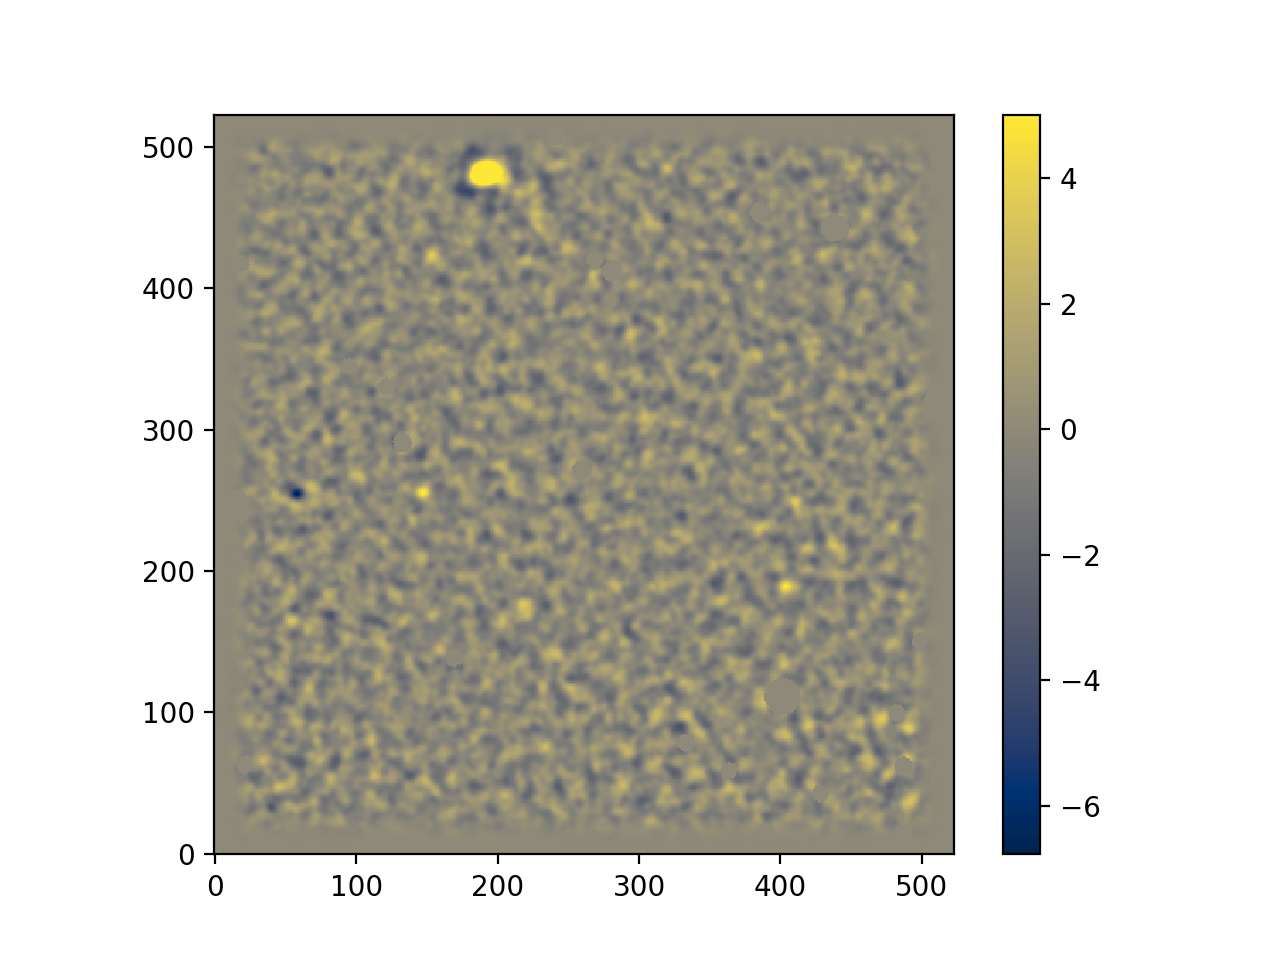

<IPython.core.display.Javascript object>


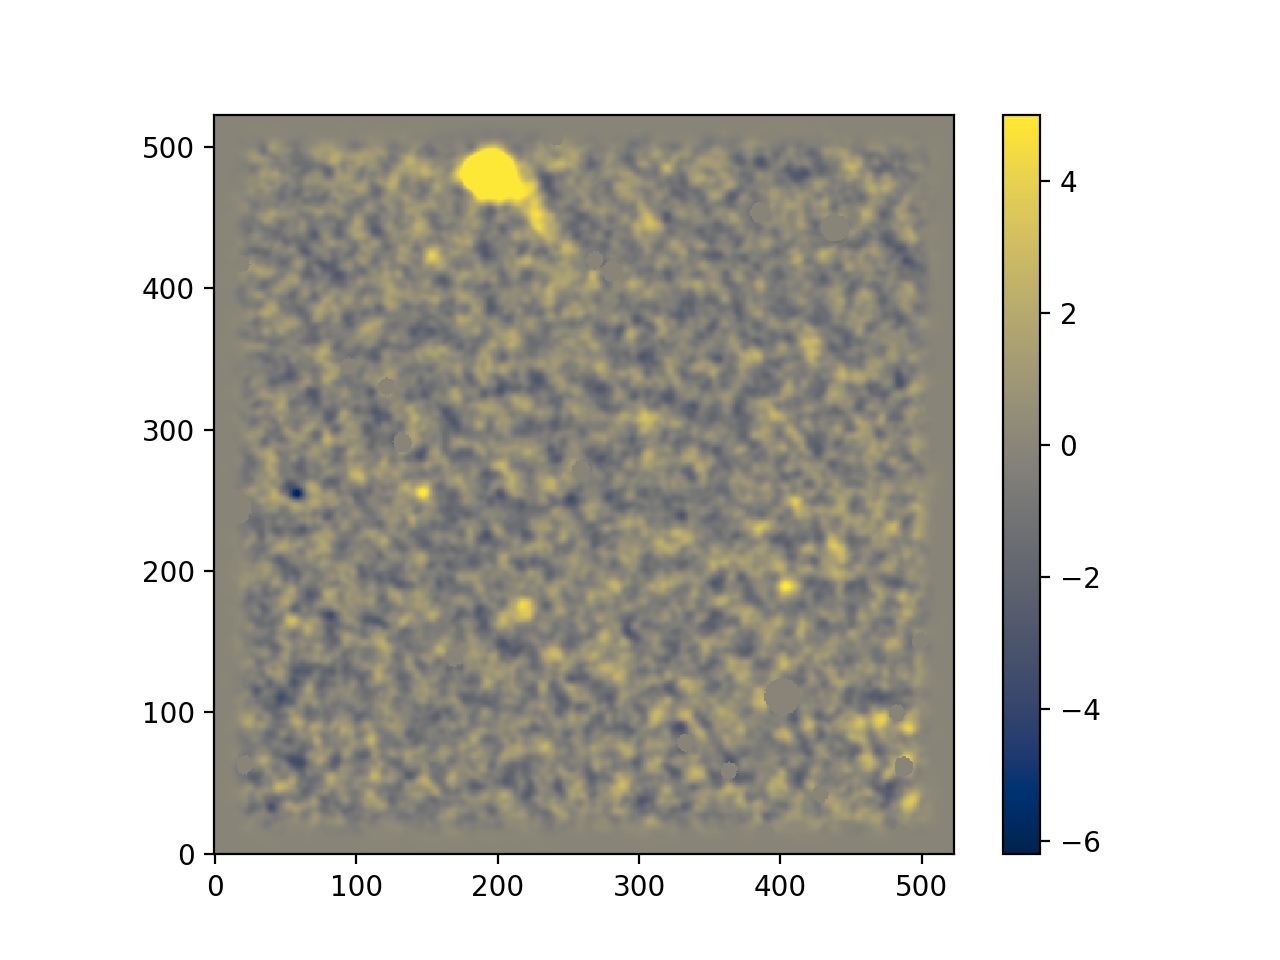

In [182]:
figure()
imshow(fildata["iter0"][21]/err0,origin="lower",cmap="cividis",vmax=5)
colorbar()

figure()
imshow(fildata["iter1"][21]/err1,origin="lower",cmap="cividis",vmax=5)
colorbar()

In [174]:
cmodel=etcc.return_cluster_model(cat["cat"],projop=projop,snrthr=6.)
cmodel_rev=etcc.return_cluster_model(cat["cat_rev"],projop=projop,snrthr=6.)

In [148]:
cmask1=return_cluster_mask(cat["cat_rev"][0]["mp_cart_coord"],abs(fildata["iter0"][5])/1.e-5,snrthr=3.,frac=0.5)

<IPython.core.display.Javascript object>


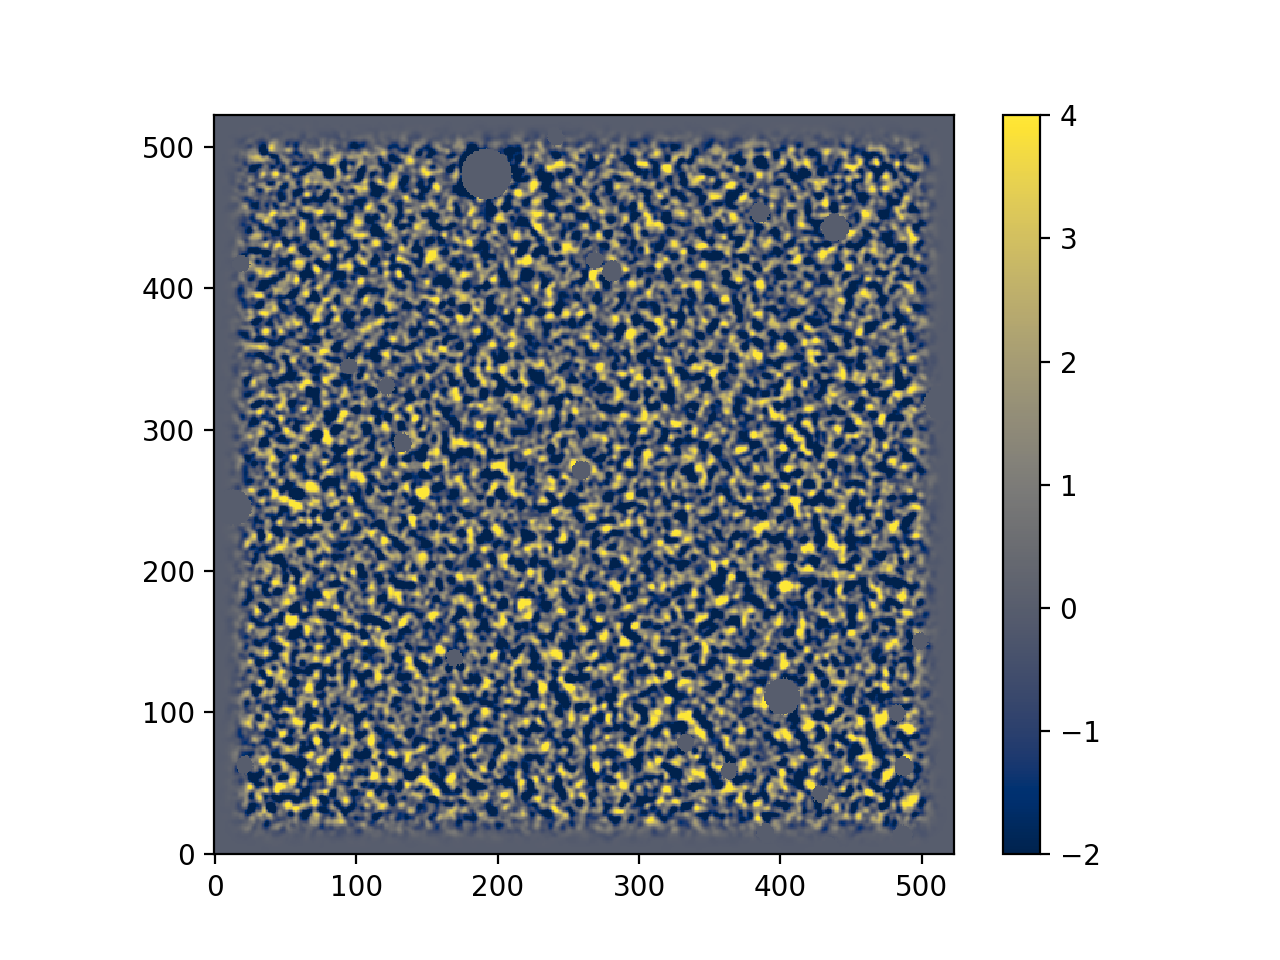

In [149]:
figure()
imshow(fildata["iter0"][5]*cmask1/1.e-5,origin="lower",vmin=-2,vmax=4,cmap="cividis")
colorbar()

<IPython.core.display.Javascript object>


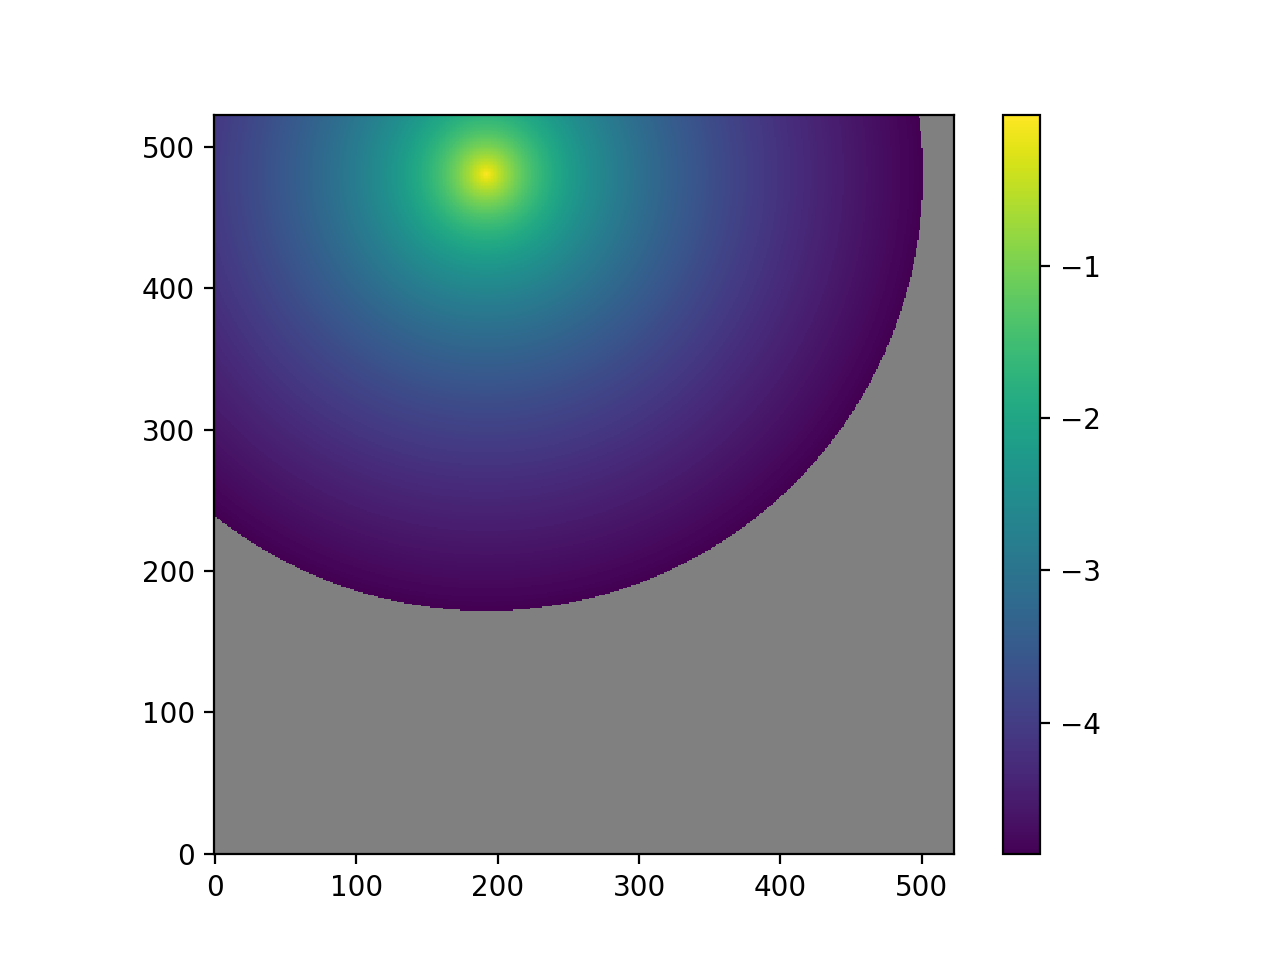

/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


<IPython.core.display.Javascript object>


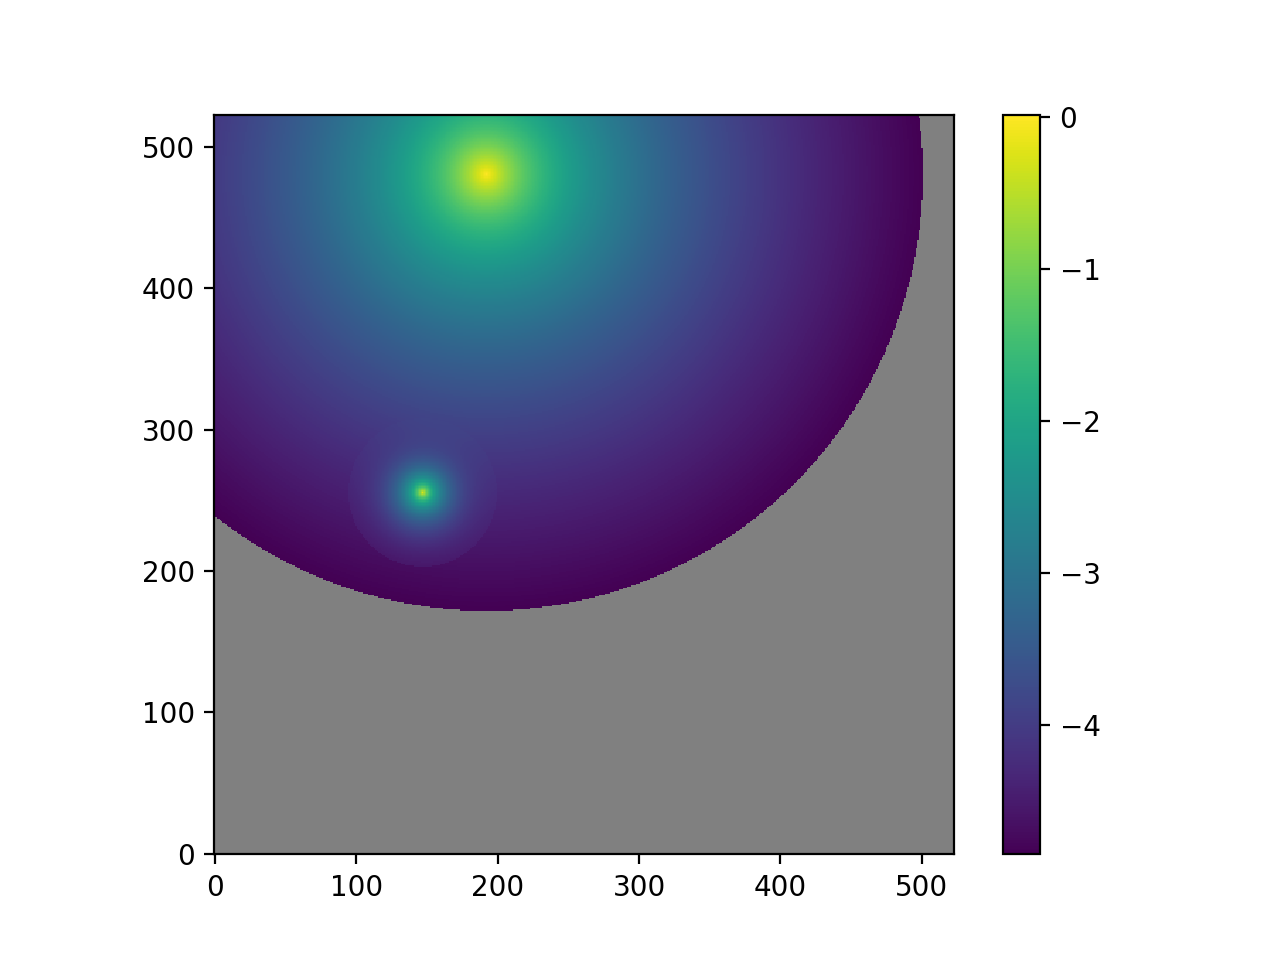

/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10


In [175]:
figure()
imshow(log10(cmodel/1e-4),origin="lower")
colorbar()

figure()
imshow(log10(cmodel_rev/1e-4),origin="lower")
colorbar()

<IPython.core.display.Javascript object>


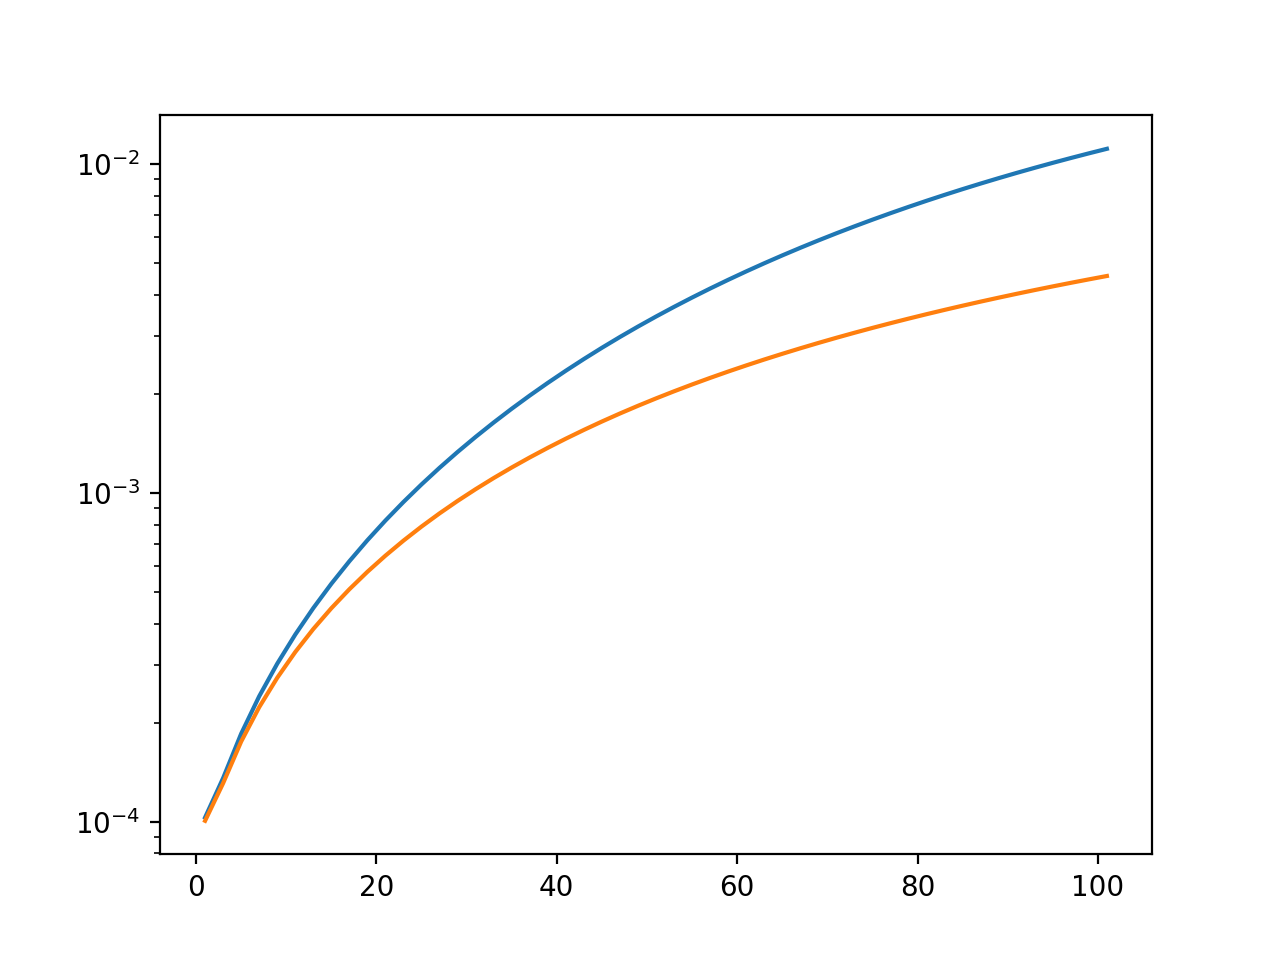

[]

In [133]:
figure()
plot(cat["theta500"],cat["err_Y500"])
plot(cat["theta500"],cat["err_Y500_rev"])
semilogy()

In [134]:
for k in cat["cat_rev"].keys():
    if k in cat["cat"].keys():
#         print cat["cat"][k]["mp_yc"],cat["cat_rev"][k]["mp_yc"]
        print cat["cat"][k]["mp_snr"],cat["cat_rev"][k]["mp_snr"],len(cat["cat_rev"][k]["snr"]),len(cat["cat"][k]["snr"])
        print cat["cat"][k]["mp_cart_coord"],cat["cat_rev"][k]["mp_cart_coord"]
    else:
#         print "-",cat["cat_rev"][k]["mp_yc"]
        print "-",cat["cat_rev"][k]["mp_snr"]

26.40513569903177 49.79738398535938 51 51
(480, 192) (480, 192)
5.7091487391003986 5.774238926825873 25 23
(255, 147) (189, 404)
5.210233997924434 6.1469176932038305 22 22
(189, 404) (255, 147)
4.311579847783908 4.459672313113898 16 8
(88, 491) (175, 218)
4.173578729993072 4.078659816523423 3 5
(249, 411) (94, 471)
4.015258709190847 4.590034525852061 11 5
(423, 154) (88, 491)
4.308666269849417 4.361518759036495 11 2
(485, 320) (423, 154)
4.243942070995975 4.29089010934037 5 2
(80, 111) (451, 228)
4.085225202294538 4.451836617447927 8 1
(57, 401) (248, 411)
4.038360621575435 4.01287281679851 3 1
(108, 321) (442, 229)
- 4.381416162113075
- 4.294223079910941
- 4.098929552960535


In [135]:
dist={}
for i in range(len(cat["cat_rev"].keys())):
    dist[i]=[]
    for j in range(len(cat["cat_rev"].keys())):
        dist[i]=dist[i] + [return_cartesian_distance(cat["cat_rev"][i]["mp_cart_coord"],cat["cat_rev"][j]["mp_cart_coord"])]
    print sort(dist[i])[1:5]/cat["cat_rev"][i]["mp_thetac"],cat["cat_rev"][i]["mp_thetac"]

[1.49825119 1.7189658  2.22027949 4.15167575] 53.0
[ 9.27796878 18.15338054 20.61824137 20.81657465] 11.0
[20.4149219  32.09236158 34.09996821 38.97151624] 9.0
[ 8.74925224 11.70416119 15.2573336  16.8784116 ] 21.0
[ 1.55945788  5.9132949   8.68205156 12.34351802] 23.0
[ 5.12393302 23.35867825 32.71176016 43.89703516] 7.0
[16.81068756 18.98578488 19.41544576 41.26160774] 7.0
[ 1.03698842  5.29382087  9.06054136 11.23193332] 15.0
[20.41153133 56.7801829  61.45584922 65.70766312] 5.0
[ 3.11096526 18.22103747 26.58009883 34.57744967] 5.0
[168.47899976 172.88724834 220.03881477 304.38487159] 1.0
[245.78738496 306.8997139  499.70977401 536.99740729] 1.0
[136.00578279 163.51074778 226.80065505 328.53831559] 1.0


In [160]:
for i in range(len(cat["cat_rev"].keys())):
    print i,len(cat["cat_rev"][i]["snr"]),cat["cat_rev"][i]["thetac"][:3],cat["cat_rev"][i]["mp_cart_coord"],cat["cat_rev"][i]["mp_thetac"],cat["cat_rev"][i]["mp_snr"]

0 51 [101.0, 99.0, 97.0] (480, 192) 53.0 49.79738398535938
1 25 [49.0, 47.0, 45.0] (189, 404) 11.0 5.774238926825873
2 22 [43.0, 41.0, 39.0] (255, 147) 9.0 6.1469176932038305
3 19 [43.0, 41.0, 39.0] (175, 218) 21.0 4.459672313113898
4 4 [27.0, 25.0, 23.0] (94, 471) 23.0 4.078659816523423
5 11 [21.0, 19.0, 17.0] (88, 491) 7.0 4.590034525852061
6 11 [21.0, 19.0, 17.0] (423, 154) 7.0 4.361518759036495
7 8 [15.0, 13.0, 11.0] (248, 411) 5.0 4.451836617447927
8 2 [3.0, 1.0] (485, 320) 1.0 4.381416162113075
9 2 [3.0, 1.0] (80, 111) 1.0 4.294223079910941
10 1 [1.0] (57, 401) 1.0 4.098929552960535


In [161]:
for i in range(len(cat["cat"].keys())):
    print i,len(cat["cat"][i]["snr"]),cat["cat"][i]["thetac"][:3],cat["cat"][i]["mp_cart_coord"],cat["cat"][i]["mp_thetac"],cat["cat"][i]["mp_snr"]

0 51 [101.0, 99.0, 97.0] (480, 192) 53.0 26.40513569903177
1 23 [45.0, 43.0, 41.0] (255, 147) 9.0 5.7091487391003986
2 22 [43.0, 41.0, 39.0] (189, 404) 11.0 5.210233997924434
3 8 [15.0, 13.0, 11.0] (88, 491) 7.0 4.311579847783908
4 5 [11.0, 9.0, 7.0] (249, 411) 5.0 4.173578729993072
5 5 [9.0, 7.0, 5.0] (423, 154) 1.0 4.015258709190847
6 2 [3.0, 1.0] (485, 320) 1.0 4.308666269849417
7 2 [3.0, 1.0] (80, 111) 1.0 4.243942070995975
8 1 [1.0] (57, 401) 1.0 4.085225202294538
9 1 [1.0] (108, 321) 1.0 4.038360621575435
